## <font size=5> <strong>Analysis about ED
 

## I. Importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import os
import warnings
import sys
import utils

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout, Embedding
from keras.losses import CategoricalCrossentropy
from keras.optimizers import SGD, Adam
warnings.filterwarnings('ignore')


## II. Importing and understanding our dataset 

### Load and preprocess datasets

In [2]:
dataset_0102 = utils.preprocess('0102')
print(dataset_0102.describe())
dataset_0304 = utils.preprocess('0304')
print(dataset_0304.describe())

merged_dataset = pd.concat([dataset_0102,dataset_0304],axis=0)
merged_dataset = merged_dataset.reset_index(drop=True)

weights = merged_dataset['WTMEC2YR']
merged_dataset = merged_dataset.drop(columns=['WTMEC2YR'])

     SEQN  DMDMARTL  DMDEDUC  RIAGENDR  RIDAGEEX  RIDRETH1      WTMEC2YR  \
0  9966.0       3.0      3.0       1.0     473.0       3.0  91352.991726   
1  9967.0       5.0      3.0       1.0     284.0       4.0  29456.680208   
2  9968.0       2.0      1.0       2.0    1012.0       3.0  27508.137821   
3  9969.0       1.0      3.0       2.0     612.0       3.0  78536.315892   
4  9970.0       5.0      1.0       1.0     200.0       2.0  34059.984716   

   SSTESTO  PAD320  PAD480  BMXBMI  SMQ020  ALQ101  DIQ010  BPQ040A  BPQ090D  \
0     4.38     1.0     2.0   30.22     1.0     1.0     2.0      NaN      2.0   
1      NaN     2.0     0.0   29.98     2.0     1.0     2.0      NaN      NaN   
2      NaN     2.0     2.0   24.62     1.0     1.0     2.0      1.0      NaN   
3      NaN     2.0     2.0   22.26     2.0     1.0     2.0      NaN      NaN   
4      NaN     1.0     3.0   39.23     NaN     NaN     2.0      NaN      NaN   

   MCQ220  
0     2.0  
1     2.0  
2     2.0  
3     2.0  
4 

## Exploratory Data Analysis (EDA)

### First, analysing the target variable:

KIQ400      1.000000
RIDAGEEX    0.418980
PAD320      0.136455
SMQ020      0.133106
PAD480      0.105632
RIDRETH1    0.098514
LBDFOLSI    0.077355
LBDLUZSI    0.056895
LBDCRYSI    0.034179
LBDVIDMS    0.033434
ALQ101      0.017958
BMXBMI      0.009716
LBDB12SI    0.003807
Name: KIQ400, dtype: float64


<Axes: xlabel='None'>

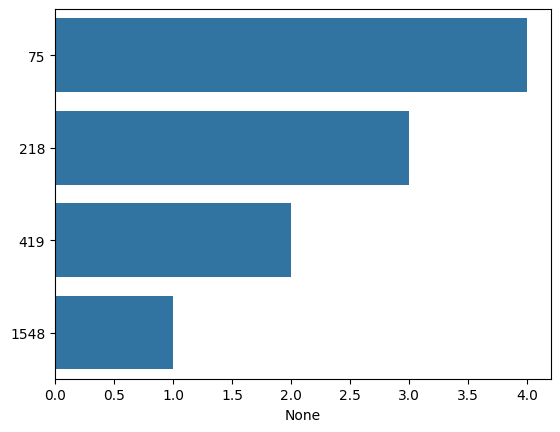

In [3]:
print(merged_dataset.corr()['KIQ400'].abs().sort_values(ascending=False))

value_counts = merged_dataset['KIQ400'].value_counts().sort_index()

sns.barplot(x=value_counts.index, y=value_counts.values, orient='h')


### Analysing the all features

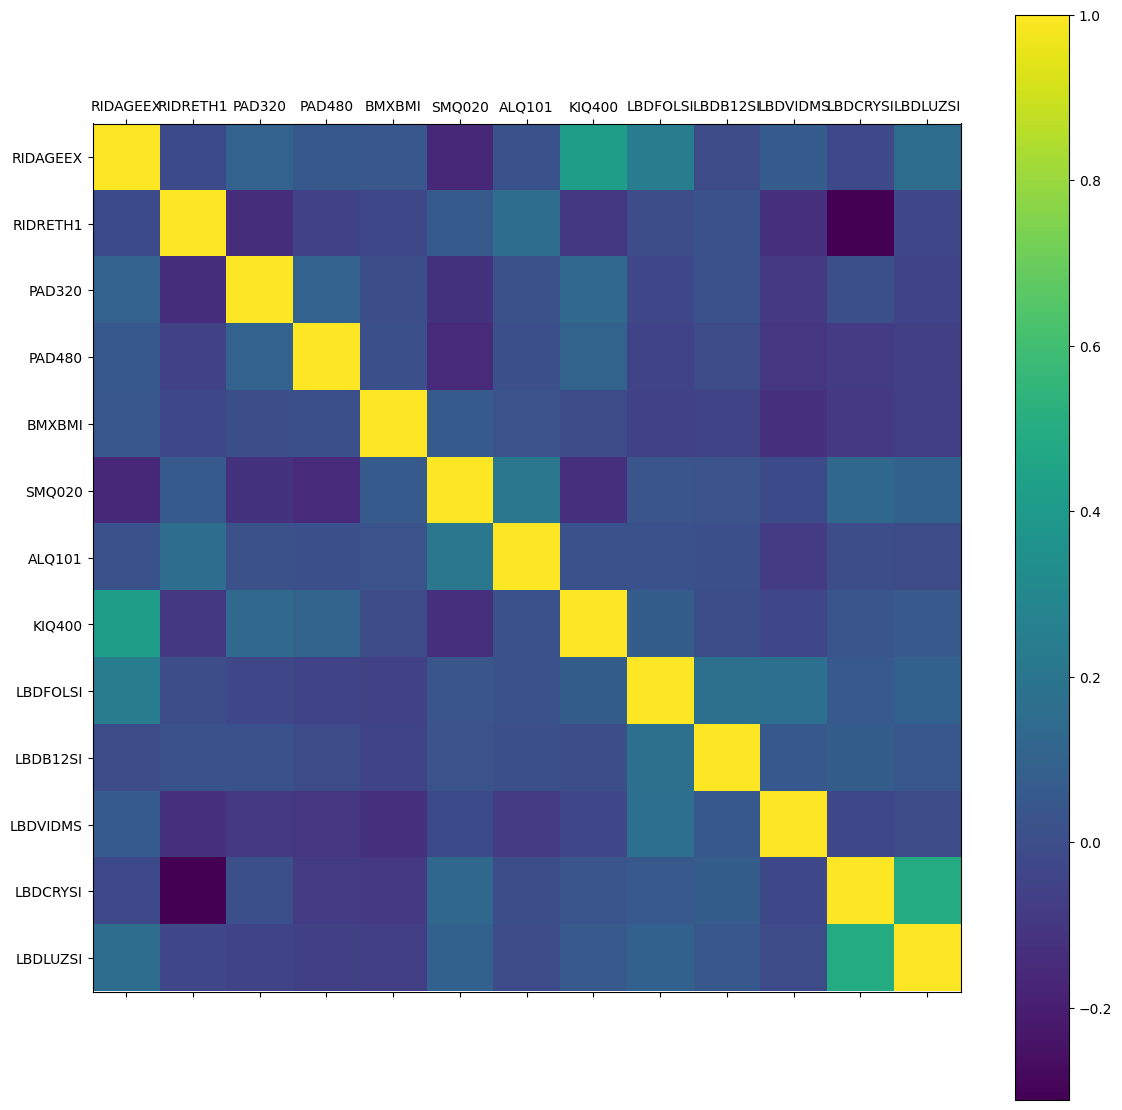

In [4]:
rcParams['figure.figsize'] = 16, 14
plt.matshow(merged_dataset.corr())
plt.yticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.xticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.colorbar()
plt.show()

## IV. Train Test split

In [5]:
predictors = merged_dataset.drop("KIQ400", axis=1)
# normalization
# for col in predictors.columns:
#     predictors[col] = (predictors[col] - predictors[col].min()) / (predictors[col].max() - predictors[col].min())

# print(predictors)
target = merged_dataset["KIQ400"]

X_train, X_test, Y_train, Y_test,weight_train,weight_test = train_test_split(predictors, target, weights,test_size=0.20, random_state=32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,weight_train.shape,weight_test.shape)

(1808, 12) (452, 12) (1808,) (452,) (1808,) (452,)


## V. Model Fitting

### Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train,sample_weight=weight_train)

Y_pred_lr = lr.predict(X_test)
#plt.scatter(X_train, Y_train, c='grey', edgecolor='black')


In [7]:
Y_pred_lr.shape

(452,)

In [8]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")


The accuracy score achieved using Logistic Regression is: 72.79 %


### Naive Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train,sample_weight=weight_train)

Y_pred_nb = nb.predict(X_test)

In [10]:
Y_pred_nb.shape

(452,)

In [11]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)

print("The accuracy score achieved using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score achieved using Naive Bayes is: 70.13 %


### SVM

In [12]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, Y_train)

Y_pred_svm = sv.predict(X_test)

In [13]:
Y_pred_svm.shape

(452,)

In [14]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 71.46 %


### K Nearest Neighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [16]:
Y_pred_knn.shape

(452,)

In [17]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 69.25 %


### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(1000):
    utils.show_progress(1000,x+1)
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train,sample_weight=weight_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

print('\n')
print('max accuracy:',max_accuracy)
print('best x:',best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)

Progress:[▉▉▉▉▉▉▉▉▉▉] 100.0%

max accuracy: 57.96
best x: 396


In [19]:
print(Y_pred_dt.shape)

(452,)


In [20]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 58.19 %


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_accuracy = 0


for x in range(1000):
    utils.show_progress(1000,x+1)
    rf = RandomForestClassifier(random_state=x,n_jobs=-1)
    rf.fit(X_train,Y_train,sample_weight=weight_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
print('\n')
print('max accuracy:',max_accuracy)
print('best x:',best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)

Progress:[▉▉▉       ] 33.3%

In [ ]:
Y_pred_rf.shape

In [ ]:
score_rf = round(accuracy_score(Y_pred_rf,Y_test)*100,2)

print("The accuracy score achieved using Random Forest is: "+str(score_rf)+" %")

## VI. Output final score

In [ ]:
scores = [score_lr,score_nb,score_svm,score_knn,score_dt,score_rf]
algorithms = ["Logistic Regression","Naive Bayes","SVM","KNN","Decision Tree","Random Forest"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(x=algorithms,y=scores)